In [1]:
from matplotlib import pyplot as plt 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping,Callback 
from keras.models import load_model, Model
from keras.layers.noise import AlphaDropout
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, precision_recall_curve
import pandas as pd
from sklearn.metrics import f1_score as f1
import itertools
from keras import backend as K
from keras.applications.vgg16 import VGG16

c:\users\jordy\anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


** Reference: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia** 

In [2]:
import os
import shutil
import numpy as np

base_dir = "C:\\Users\\Jordy\\Desktop\\9° Semestre\\Mestrado\\chest_xray"

sourceN = base_dir + "\\train\\NORMAL\\"
destN = base_dir + "\\val\\NORMAL"
sourceP = base_dir + "\\train\\PNEUMONIA"
destP = base_dir + "\\val\\PNEUMONIA"

train_dir = base_dir + '\\train'
val_dir = base_dir + '\\val'
test_dir = base_dir + '\\test'

#filesN = os.listdir(sourceN)
#filesP = os.listdir(sourceP)

print(len(os.listdir(sourceN)))
print(len(os.listdir(sourceP)))
print(len(os.listdir(destN)))
print(len(os.listdir(destP)))


#for f in filesN:
#    if np.random.rand(1) < 0.2:
#        shutil.move(sourceN + '\\'+ f, destN + '\\'+ f)
        
#for i in filesP:
#    if np.random.rand(1) < 0.2:
#        shutil.move(sourceP + '\\'+ i, destP + '\\'+ i)


926
1074
424
778


In [3]:
lrn = 1.0e-4   
epochs = 10      
batch_size =50
img_rows, img_cols,img_channels,num_classes = 224, 224, 3, 2
activ = 'selu'
data_size = 1999
val_size = 1202
test_size = 480

K.clear_session()

In [4]:
# Train
train_datagen = ImageDataGenerator(        
        shear_range=0.2,
        zoom_range=0.2) 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        shuffle=False)

# Val
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow_from_directory(
        val_dir,
        shuffle=False,
        batch_size=batch_size,
        target_size=(img_rows, img_cols))
    
# Test
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        target_size=(img_rows, img_cols))

Found 1999 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [5]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channels))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x1 = Dense(1024, activation=activ,kernel_initializer='lecun_normal')(x)
dp1 = AlphaDropout(0.3)(x1)
x2 = Dense(1024, activation=activ,kernel_initializer='lecun_normal')(dp1)
dp2 = AlphaDropout(0.3)(x2)

# and a logistic layer
predictions = Dense(num_classes, activation='softmax')(dp2)

In [6]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
#for layer in model.layers[:249]:
#   layer.trainable = False
#for layer in model.layers[249:]:
#   layer.trainable = True

In [8]:
model.compile(loss='categorical_crossentropy',
               optimizer=Adam(lr=lrn),
               metrics=['accuracy'])

In [9]:
checkpoint = ModelCheckpoint('meuModelo.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

In [10]:
early = EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=0,
                      verbose=0, 
                      mode='auto')

In [11]:
class LivePlot(Callback):    
    def _init_(self, metric):
        self.metric = 'accuracy' 
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.train_metric_history = []
        self.val_metric_history = []        
        self.fig = plt.figure()        
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):        
        self.logs.append(logs)
        self.x.append(self.i)
        self.train_metric_history.append(logs.get('acc'))
        self.val_metric_history.append(logs.get('val_'+'acc'))
        self.i += 1        
        plt.plot(self.x, self.train_metric_history, label='acc')
        plt.plot(self.x, self.val_metric_history, label='val_'+'acc')
        plt.legend()
        plt.show(); 
        
plot = LivePlot()

Epoch 1/10
39/39 [==============================] - 74s 2s/step - loss: 0.7436 - acc: 0.7474 - val_loss: 1.3509 - val_acc: 0.7908


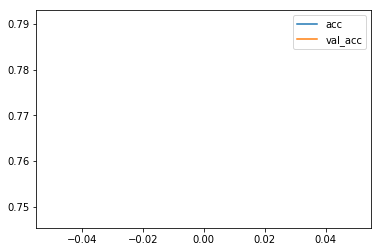

Epoch 2/10
39/39 [==============================] - 68s 2s/step - loss: 0.4048 - acc: 0.8702 - val_loss: 0.7580 - val_acc: 0.8900


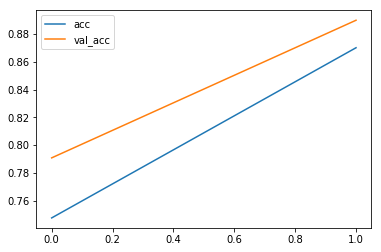

Epoch 3/10
39/39 [==============================] - 68s 2s/step - loss: 0.3766 - acc: 0.8805 - val_loss: 0.7306 - val_acc: 0.8917


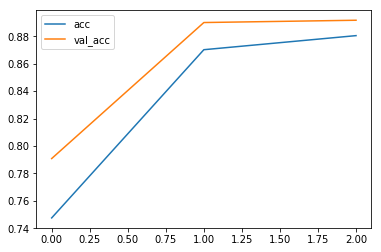

Epoch 4/10
39/39 [==============================] - 68s 2s/step - loss: 0.3948 - acc: 0.8718 - val_loss: 0.5631 - val_acc: 0.9125


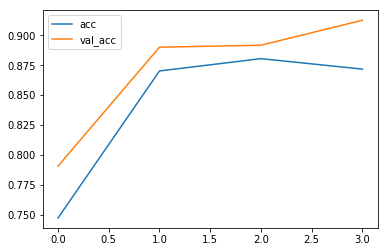

Epoch 5/10
39/39 [==============================] - 69s 2s/step - loss: 0.2606 - acc: 0.9067 - val_loss: 0.5717 - val_acc: 0.9225


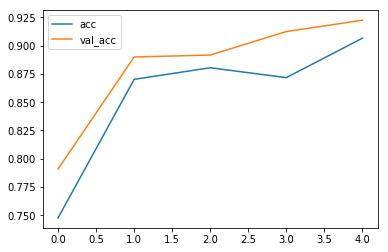

In [12]:
logs = model.fit_generator(train_generator,
                           steps_per_epoch= data_size // batch_size,
                           epochs=epochs,
                           validation_data=val_generator,
                           validation_steps= val_size // batch_size,
                           callbacks=[checkpoint,early,plot],
                           verbose=1)

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[415   9]
 [ 84 694]]
Normalized confusion matrix
[[0.98 0.02]
 [0.11 0.89]]


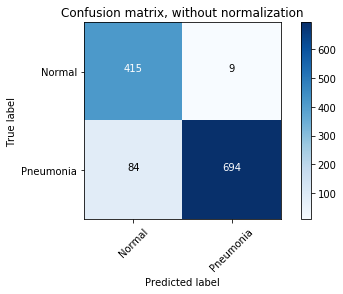

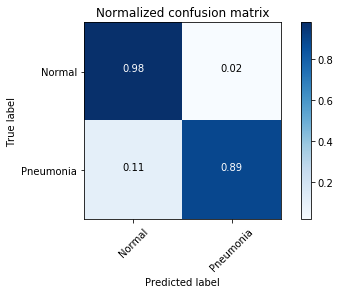

F1 Score: 0.92381%


In [14]:
class_names = ['Normal','Pneumonia'] 

Y_pred = model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_generator.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

print("F1 Score: %.5f%%" % f1(val_generator.classes, y_pred, average='weighted'))
#precision, recall, _ = precision_recall_curve(val_generator.classes, y_pred)
#print("Precision Score: %.5f%%" % precision)
#print("Recall Score: %.5f%%" % recall)

In [15]:
K.clear_session()